## Download del dataset dalla libreria medmnist

In [40]:
!pip install medmnist

In [41]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from numpy import ravel

from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from medmnist.dataset import PneumoniaMNIST
Dataset = PneumoniaMNIST
dataset = Dataset(split='val', download=True)
label_map = dataset.info['label']

Using downloaded and verified file: /Users/angelolongano/.medmnist/pneumoniamnist.npz


# Informazioni su PneumoniaMNIST
PneumoniaMNIST si basa su un set di dati precedenti di __5.856 immagini__ radiografiche del torace pediatrico.  
Il compito è la classificazione a classi binarie della polmonite rispetto alla normalità. Abbiamo diviso il set di formazione di origine con un rapporto di 9:1 in set di formazione e di convalida e abbiamo usato il set di convalida di origine come set di test.  
Le immagini di partenza sono in scala di grigi e le loro dimensioni sono (384-2.916)×(127-2.713). Le immagini vengono ritagliate al centro e ridimensionate in __1×28×28__.

Le immagini sono classificate:
- 0: __normale__
- 1: __polmonite__

Divisione del dataset:
{'train': 4708, 'val': 524, 'test': 624}


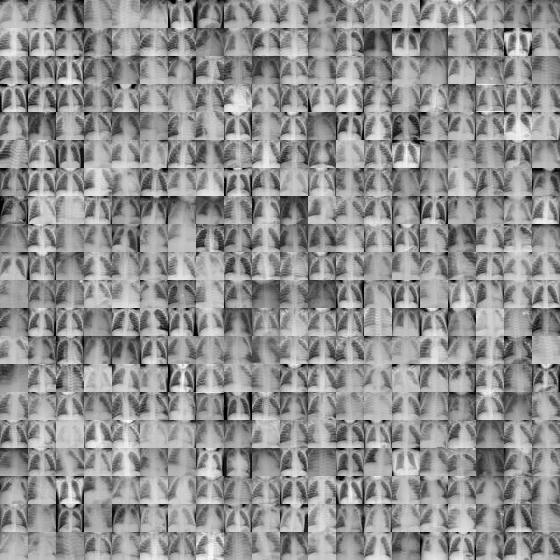

In [42]:
print("Divisione del dataset:")
print(dataset.info['n_samples'])
dataset.montage(20)

# Estrazione del train set e del test set

In [43]:
X_train, Y_train = Dataset(split='train',download=True).imgs, Dataset(split='train',download=True).labels
X_test, Y_test = Dataset(split='test',download=True).imgs, Dataset(split='test',download=True).labels

Using downloaded and verified file: /Users/angelolongano/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/angelolongano/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/angelolongano/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/angelolongano/.medmnist/pneumoniamnist.npz


In [44]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [45]:
scaler = StandardScaler().set_output(transform="pandas")

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [46]:
Y_train

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]], dtype=uint8)

In [47]:
Y_train = ravel(Y_train)
Y_test = ravel(Y_test)

In [48]:
Y_train

array([1, 1, 1, ..., 1, 0, 1], dtype=uint8)

In [49]:
# Distribuzione delle classi nel train set
print(pd.Series(Y_train).value_counts())

1    3494
0    1214
Name: count, dtype: int64


In [50]:
print(pd.Series(Y_test).value_counts())

1    390
0    234
Name: count, dtype: int64


# Classificazione Binaria

## Minimi vicini

In [51]:
grid = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1), {'n_neighbors': range(1, 1000)}, n_iter=10, n_jobs=-1,random_state=0)
search_params = grid.fit(X_train, Y_train)
search_params.best_params_

{'n_neighbors': 32}

In [52]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_neighbors","mean_test_score","mean_score_time"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

,RANK_TEST_SCORE,PARAM_N_NEIGHBORS,MEAN_TEST_SCORE,MEAN_SCORE_TIME
8,1,32,"0,94328841","0,24899898"
1,2,78,"0,93542782","0,27527885"
9,3,357,"0,91036436","0,26193299"
6,4,400,"0,90632881","0,31975026"
7,5,453,"0,90207982","0,35170674"
5,6,532,"0,89400895","0,35702338"
3,7,614,"0,88721015","0,37392626"
0,8,723,"0,87467888","0,42389612"
2,9,878,"0,85705228","0,42592678"
4,10,904,"0,85429107","0,44051681"


(0.0, 1.0)

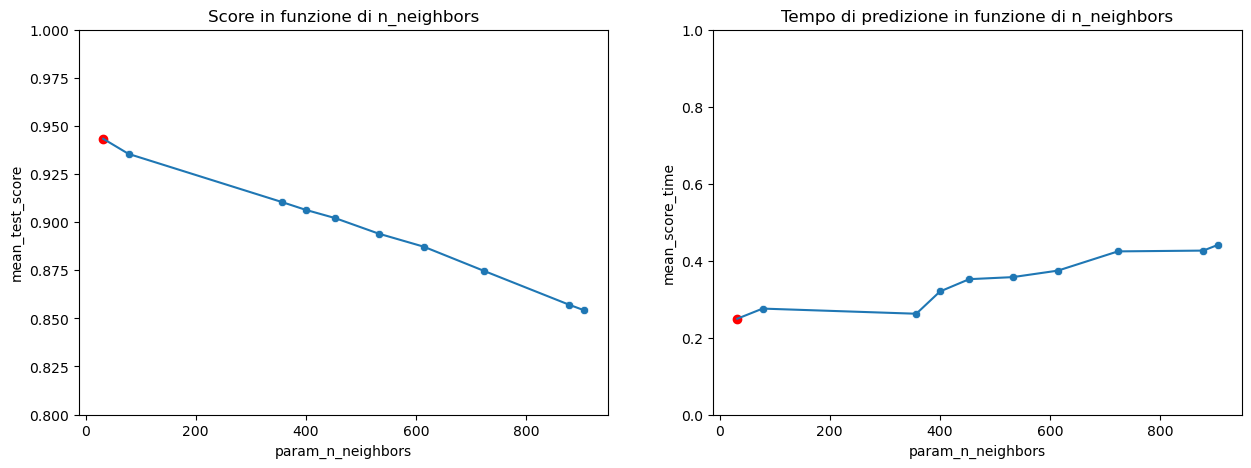

In [53]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
best_n_neighbors = best.param_n_neighbors
ax[0].scatter(best.param_n_neighbors, best.mean_test_score, color='red')
ax[0].set_ylim(0.8,1)

sns.lineplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1]).set_title('Tempo di predizione in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1])
ax[1].scatter(best.param_n_neighbors, best.mean_score_time, color='red')
ax[1].set_ylim(0,1)

In [54]:
cls = KNeighborsClassifier(n_neighbors=best_n_neighbors,n_jobs=-1)
cls.fit(X_train, Y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=32)

In [55]:
y_pred_kn = cls.predict(X_test)

## Random Forest

In [56]:
grid = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1,random_state=0), {'n_estimators': range(1, 1000), 'max_depth': range(1,100)}, n_iter=10, n_jobs=-1,random_state=0)
search_params = grid.fit(X_train, Y_train)
search_params.best_params_

{'n_estimators': 337, 'max_depth': 69}

In [57]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_estimators","param_max_depth","mean_fit_time","mean_test_score"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

,RANK_TEST_SCORE,PARAM_N_ESTIMATORS,PARAM_MAX_DEPTH,MEAN_FIT_TIME,MEAN_TEST_SCORE
0,1,337,69,"12,97175331","0,94923614"
2,2,656,43,"24,15715852","0,94923569"
8,3,380,87,"12,43042140","0,94859875"
6,4,737,98,"26,49969645","0,94859830"
3,5,937,46,"34,68051152","0,94838643"
1,6,611,44,"22,82411852","0,94838598"
4,7,265,22,"9,68978190","0,94817435"
9,8,82,56,"2,82570601","0,94774904"
5,9,36,97,"1,31284108","0,94477416"
7,9,36,43,"1,39796619","0,94477416"


(0.0, 20.0)

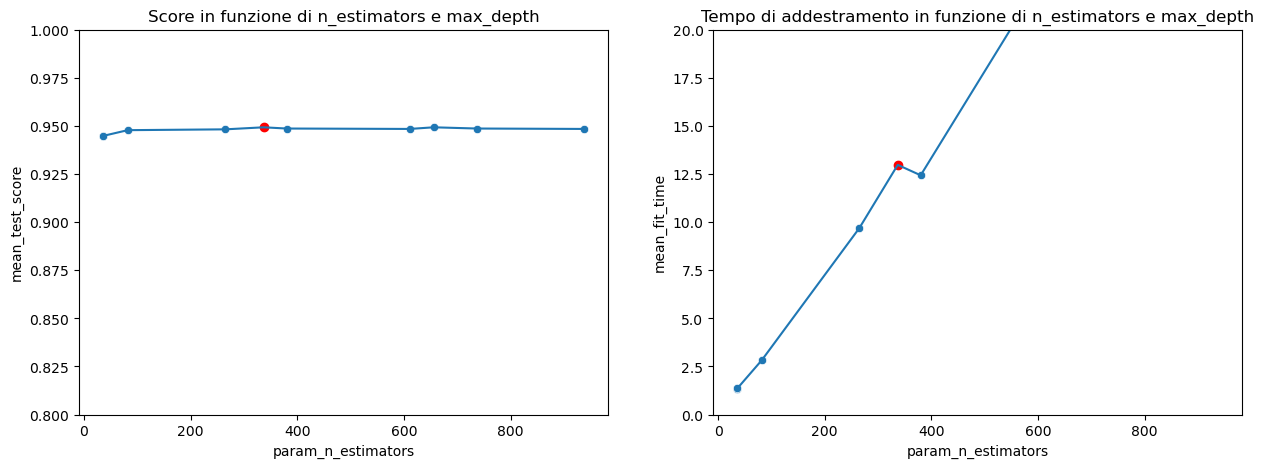

In [58]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_estimators', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_estimators e max_depth')
sns.scatterplot(data=df, x='param_n_estimators', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
best_n_estimators = best.param_n_estimators
best_max_depth = best.param_max_depth
ax[0].scatter(best.param_n_estimators, best.mean_test_score, color='red')
ax[0].set_ylim(0.8,1)

sns.lineplot(data=df, x='param_n_estimators', y='mean_fit_time', ax=ax[1]).set_title('Tempo di addestramento in funzione di n_estimators e max_depth')
sns.scatterplot(data=df, x='param_n_estimators', y='mean_fit_time', ax=ax[1])
ax[1].scatter(best.param_n_estimators, best.mean_fit_time, color='red')
ax[1].set_ylim(0,20)

In [59]:
cls = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, n_jobs=-1)
cls.fit(X_train, Y_train)

RandomForestClassifier(max_depth=69, n_estimators=337, n_jobs=-1)

In [60]:
y_pred_rf = cls.predict(X_test)

## Minimi vicini vs Random Forest

In [61]:
# Differenza di accuratezza tra i due modelli
print(f"Minimi vicini: {accuracy_score(Y_test, y_pred_kn)}")
print(f"Random Forest: {accuracy_score(Y_test, y_pred_rf)}")

Minimi vicini: 0.8237179487179487
Random Forest: 0.8461538461538461


In [62]:
print(f"Minimi vicini: \n{classification_report(Y_test, y_pred_kn)}\n\n")
print(f"Random Forest: \n{classification_report(Y_test, y_pred_rf)}")

Minimi vicini: 
              precision    recall  f1-score   support

           0       0.94      0.56      0.71       234
           1       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



Random Forest: 
              precision    recall  f1-score   support

           0       0.94      0.63      0.75       234
           1       0.81      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.85      0.84       624



Text(0.5, 1.0, 'Random Forest')

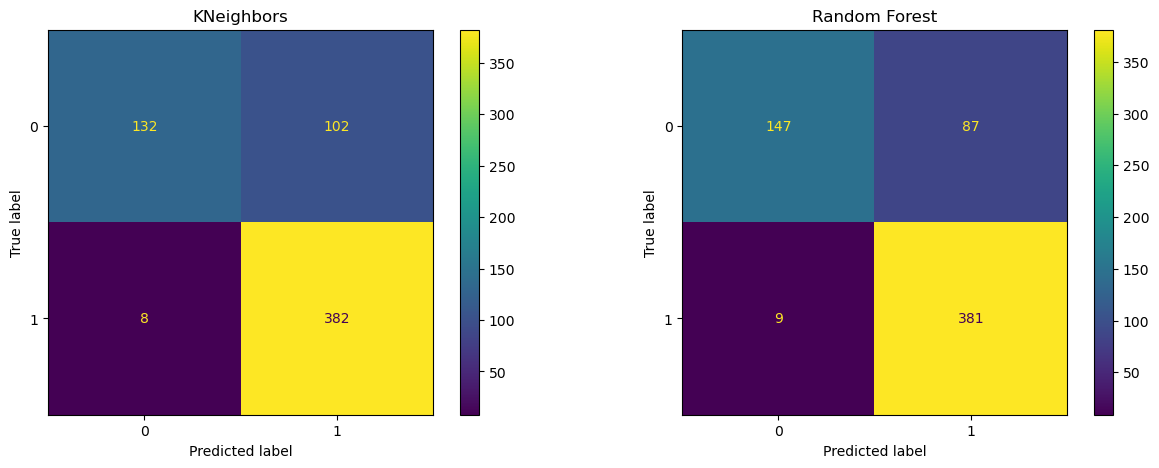

In [63]:
matrix_kn = confusion_matrix(Y_test, y_pred_kn)
matrix_rf = confusion_matrix(Y_test, y_pred_rf)

fig, ax = plt.subplots(ncols=2, figsize=(15,5))

ConfusionMatrixDisplay(matrix_kn).plot(ax=ax[0])
ax[0].set_title('KNeighbors')
ConfusionMatrixDisplay(matrix_rf).plot(ax=ax[1])
ax[1].set_title('Random Forest')

# LDA

In [64]:
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, Y_train)
X_test_lda = lda.transform(X_test)

## Minimi vicini con LDA

In [65]:
grid = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1), {'n_neighbors': range(1, 1000)}, n_iter=10, n_jobs=-1,random_state=0)
search_params = grid.fit(X_train_lda, Y_train)
search_params.best_params_

{'n_neighbors': 532}

In [66]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_neighbors","mean_test_score","mean_score_time"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

,RANK_TEST_SCORE,PARAM_N_NEIGHBORS,MEAN_TEST_SCORE,MEAN_SCORE_TIME
5,1,532,"0,98003208","0,06139016"
6,1,400,"0,98003208","0,04839816"
7,1,453,"0,98003208","0,05092201"
9,1,357,"0,98003208","0,03662405"
0,5,723,"0,97960768","0,15208020"
3,6,614,"0,97960746","0,10064054"
1,7,78,"0,97939469","0,05123577"
2,8,878,"0,97918328","0,10558782"
4,8,904,"0,97918328","0,07695069"
8,10,32,"0,97727132","0,03707275"


(0.0, 1.0)

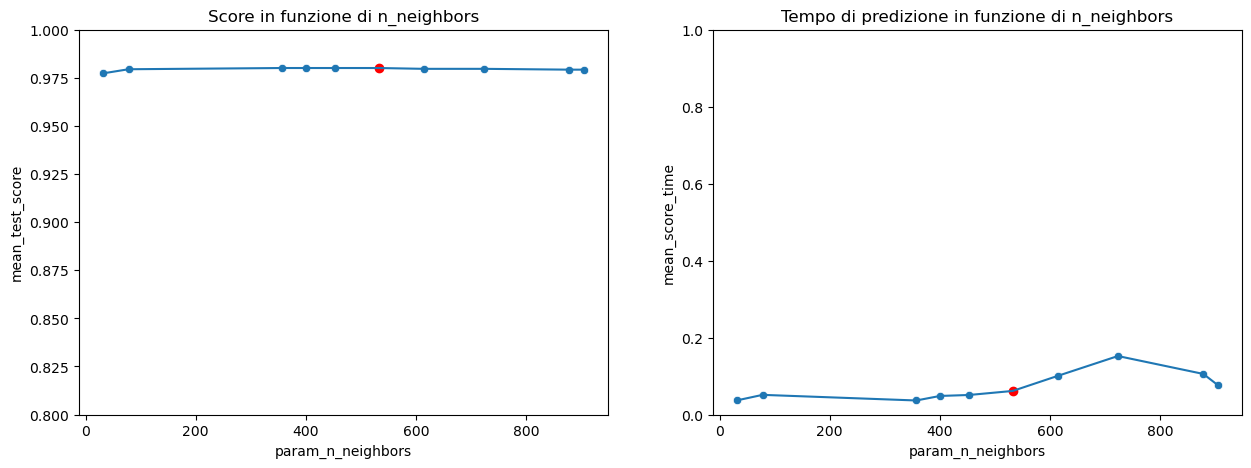

In [67]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
best_n_neighbors = best.param_n_neighbors
ax[0].scatter(best.param_n_neighbors, best.mean_test_score, color='red')
ax[0].set_ylim(0.8,1)

sns.lineplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1]).set_title('Tempo di predizione in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1])
ax[1].scatter(best.param_n_neighbors, best.mean_score_time, color='red')
ax[1].set_ylim(0,1)

In [68]:
cls = KNeighborsClassifier(n_neighbors=best_n_neighbors,n_jobs=-1)
cls.fit(X_train_lda, Y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=532)

In [69]:
y_pred_lda_kn = cls.predict(X_test_lda)

## Random Forest con LDA

In [70]:
grid = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1,random_state=0), {'n_estimators': range(1, 1000), 'max_depth': range(1,100)}, n_iter=10, n_jobs=-1,random_state=0)
search_params = grid.fit(X_train_lda, Y_train)
search_params.best_params_

{'n_estimators': 337, 'max_depth': 69}

In [71]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_estimators","param_max_depth","mean_fit_time","mean_test_score"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

,RANK_TEST_SCORE,PARAM_N_ESTIMATORS,PARAM_MAX_DEPTH,MEAN_FIT_TIME,MEAN_TEST_SCORE
0,1,337,69,"0,72709217","0,96792589"
1,1,611,44,"1,41087394","0,96792589"
2,1,656,43,"1,60876884","0,96792589"
3,1,937,46,"2,64019203","0,96792589"
4,1,265,22,"0,55729933","0,96792589"
5,1,36,97,"0,07637100","0,96792589"
6,1,737,98,"1,79267759","0,96792589"
7,1,36,43,"0,06804290","0,96792589"
8,1,380,87,"0,85161915","0,96792589"
9,1,82,56,"0,13279915","0,96792589"


(0.0, 5.0)

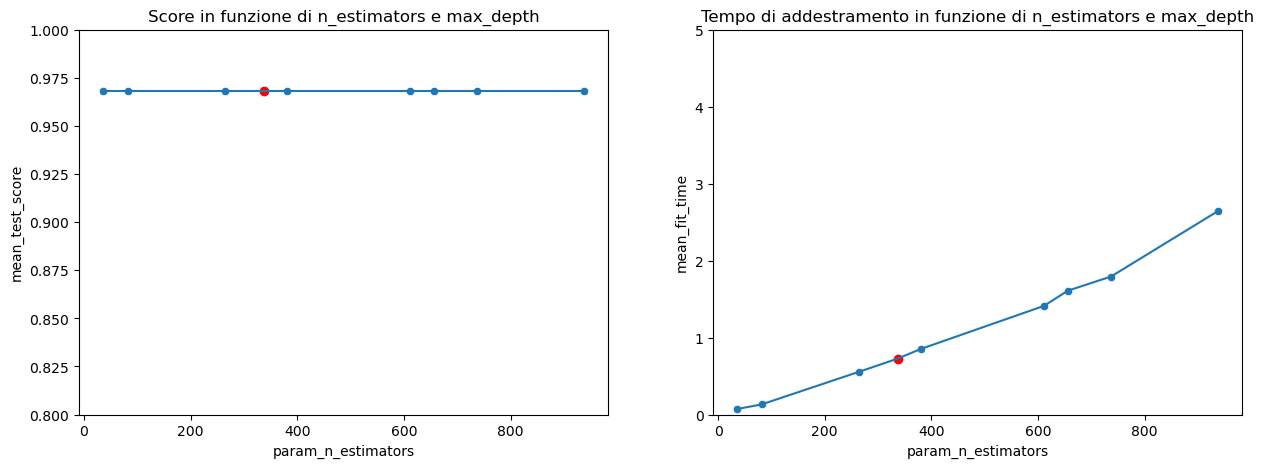

In [72]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_estimators', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_estimators e max_depth')
sns.scatterplot(data=df, x='param_n_estimators', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
best_n_estimators = best.param_n_estimators
best_max_depth = best.param_max_depth
ax[0].scatter(best.param_n_estimators, best.mean_test_score, color='red')
ax[0].set_ylim(0.8,1)

sns.lineplot(data=df, x='param_n_estimators', y='mean_fit_time', ax=ax[1]).set_title('Tempo di addestramento in funzione di n_estimators e max_depth')
sns.scatterplot(data=df, x='param_n_estimators', y='mean_fit_time', ax=ax[1])
ax[1].scatter(best.param_n_estimators, best.mean_fit_time, color='red')
ax[1].set_ylim(0,5)

In [73]:
cls = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, n_jobs=-1)
cls.fit(X_train_lda, Y_train)

RandomForestClassifier(max_depth=69, n_estimators=337, n_jobs=-1)

In [74]:
y_pred_lda_rf = cls.predict(X_test_lda)

## Minimi vicini vs Random Forest con LDA

In [75]:
# Differenza di accuratezza tra i due modelli
print(f"Minimi vicini: {accuracy_score(Y_test, y_pred_lda_kn)}")
print(f"Random Forest: {accuracy_score(Y_test, y_pred_lda_rf)}")

Minimi vicini: 0.8333333333333334
Random Forest: 0.8365384615384616


In [76]:
print(f"Minimi vicini: \n{classification_report(Y_test, y_pred_lda_kn)}\n\n")
print(f"Random Forest: \n{classification_report(Y_test, y_pred_lda_rf)}")

Minimi vicini: 
              precision    recall  f1-score   support

           0       0.95      0.59      0.73       234
           1       0.80      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.78      0.80       624
weighted avg       0.85      0.83      0.82       624



Random Forest: 
              precision    recall  f1-score   support

           0       0.95      0.60      0.73       234
           1       0.80      0.98      0.88       390

    accuracy                           0.84       624
   macro avg       0.87      0.79      0.81       624
weighted avg       0.86      0.84      0.83       624



Text(0.5, 1.0, 'Random Forest')

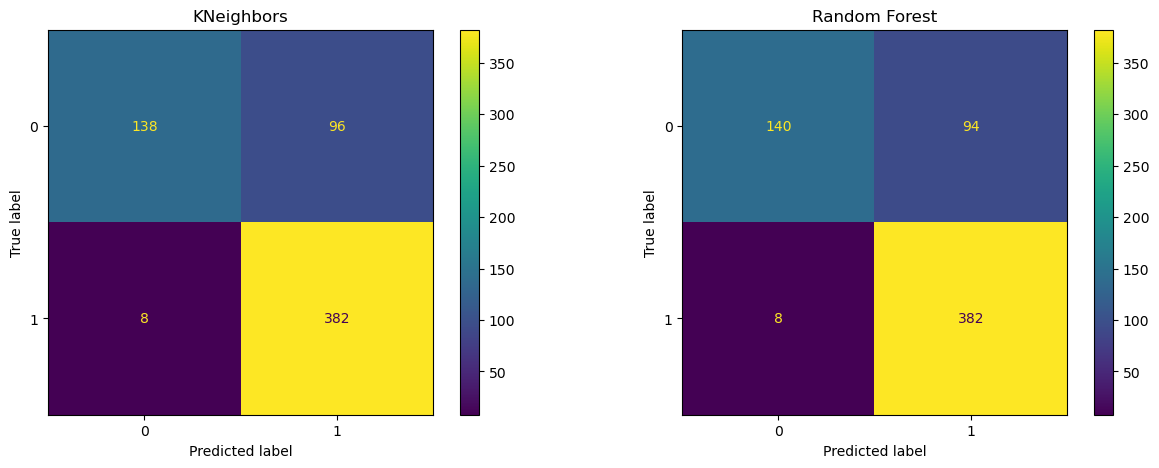

In [77]:
matrix_kn = confusion_matrix(Y_test, y_pred_lda_kn)
matrix_rf = confusion_matrix(Y_test, y_pred_lda_rf)

fig, ax = plt.subplots(ncols=2, figsize=(15,5))

ConfusionMatrixDisplay(matrix_kn).plot(ax=ax[0])
ax[0].set_title('KNeighbors')
ConfusionMatrixDisplay(matrix_rf).plot(ax=ax[1])
ax[1].set_title('Random Forest')

# Conclusioni

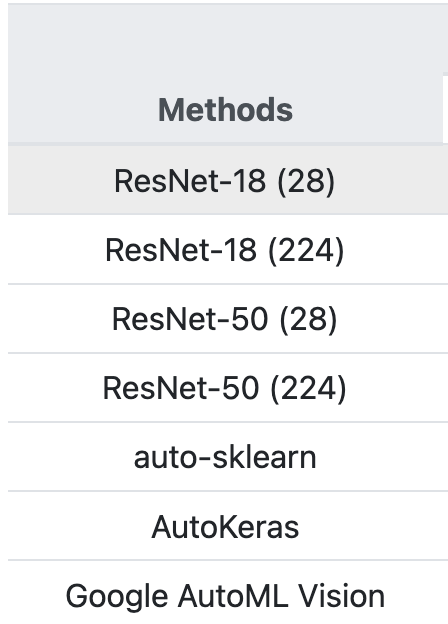
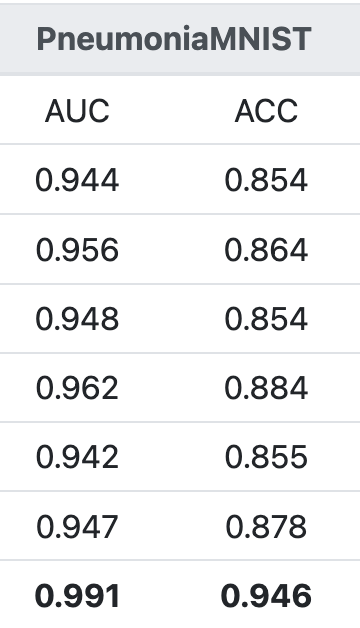
